# Selecció del repositori

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/Model_Training')

!pip install detecto

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Comprobam si esteim en el directori correcte
!ls

frozen_inference_graph.pb  pipeline.config  train_labels      val_labels
models			   resnet_101.pth   train_labels.csv  val_labels.csv
Model_training.ipynb	   train_images     val_images


In [ ]:
import tensorflow as tf
from tensorflow.tools.graph_transforms import TransformGraph
from tensorflow.core.framework import graph_pb2
import copy

def load_graph(filename):
    graph_def = tf.GraphDef()
    with tf.gfile.FastGFile(filename, 'rb') as f:
        graph_def.ParseFromString(f.read())
    return graph_def


def transform_graph(input_graph, output_graph=None):
    """ Use to run different transform function on the input graph and generate a output graph. """
    if isinstance(input_graph, graph_pb2.GraphDef):
        graph_def = input_graph
    else:
        graph_def = load_graph(input_graph)
        
    new_graph_def = TransformGraph(graph_def, ['input_placeholder/input_image'], ['predicated_output'], 
            ['strip_unused_nodes(type=float, shape="1,28,28,1")', 'remove_nodes(op=Identity, op=CheckNumerics, op=Switch)', 
            'fold_constants(ignore_errors=true)', 'fold_batch_norms', 'fold_old_batch_norms', 'sort_by_execution_order'])

    if output_graph == None:
        return new_graph_def

    # save new graph
    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(new_graph_def.SerializeToString())
    
    # tf.io.write_graph(od_graph_def, "", output_graph, as_text=False)


def convert_to_constant(input_graph, output_graph=None):
    """ Convert the placeholders in graph to constant nodes. """
    if isinstance(input_graph, graph_pb2.GraphDef):
        graph_def = input_graph
    else:
        graph_def = load_graph(input_graph)

    keep_prob = tf.constant(1.0, dtype=tf.float32, shape=[], name='keep_prob')
    weight_factor = tf.constant(1.0, dtype=tf.float32, shape=[], name='weight_factor')
    is_training = tf.constant(False, dtype=tf.bool, shape=[], name='is_training')

    new_graph_def = graph_pb2.GraphDef()

    for node in graph_def.node:
        if node.name == 'keep_prob':
            new_graph_def.node.extend([keep_prob.op.node_def])

        elif node.name == 'weight_factor':
            new_graph_def.node.extend([weight_factor.op.node_def])

        elif node.name == 'is_training':
            new_graph_def.node.extend([is_training.op.node_def])

        else:
            new_graph_def.node.extend([copy.deepcopy(node)])

    
    if output_graph == None:
        return new_graph_def

    # save new graph
    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(new_graph_def.SerializeToString())


def optimize_batch_normalization(input_graph, output_graph=None):
    """ Optimize the batch normalization block. """
    if isinstance(input_graph, graph_pb2.GraphDef):
        graph_def = input_graph
    else:
        graph_def = load_graph(input_graph)

    new_graph_def = graph_pb2.GraphDef()
    unused_attrs = ['is_training']              # Attributes of FusedBatchNorm. Not needed during inference.

    # All the node names are specific to my ocr model.
    # All the input names are found manually from tensorboard
    for node in graph_def.node:
        modified_node = copy.deepcopy(node)
        if node.name.startswith("conv"):        # True for Convolutional Layers
            starting_name = ""
            if node.name.startswith("conv1"):
                starting_name = "conv1"

            elif node.name.startswith("conv2"):
                starting_name = "conv2"

            elif node.name.startswith("conv3"):
                starting_name = "conv3"

            elif node.name.startswith("conv4"):
                starting_name = "conv4"

            # Do not add the cond block and its child nodes. 
            # This is only needed during training.
            if "cond" in node.name and not node.name.endswith("FusedBatchNorm"):
                continue

            if node.op == "FusedBatchNorm" and node.name.endswith("FusedBatchNorm"):
                if bool(starting_name):
                    # Changing the name to remove one block hierarchy and changing inputs.
                    modified_node.name = "{0}/{0}/batch_norm/FusedBatchNorm".format(starting_name) 
                    modified_node.input[0] = "{}/Conv2D".format(starting_name)
                    modified_node.input[1] = "{}/batch_norm/gamma".format(starting_name)
                    modified_node.input[2] = "{}/batch_norm/beta".format(starting_name)
                    modified_node.input[3] = "{}/batch_norm/moving_mean".format(starting_name)
                    modified_node.input[4] = "{}/batch_norm/moving_variance".format(starting_name)

                    # Deleting unused attributes
                    for attr in unused_attrs:
                        if attr in modified_node.attr:
                            del modified_node.attr[attr]

            if node.name.endswith('activation'):
                if bool(starting_name):
                    modified_node.input[0] = "{0}/{0}/batch_norm/FusedBatchNorm".format(starting_name)

        elif node.name.startswith("fc") or node.name.startswith("logits"):  # True for fully connected layers
            starting_name = ""
            if node.name.startswith("fc1"):
                starting_name = "fc1"

            elif node.name.startswith("fc2"):
                starting_name = "fc2"

            elif node.name.startswith("logits"):
                starting_name = "logits"

            # Do not add cond, cond_1 and moments block of batch normalization
            if "cond" in node.name or "moments" in node.name:
                continue

            # Change input of batchnorm/add
            if node.name.endswith('batchnorm/add'):
                modified_node.input[0] = "{}/batch_norm/moving_variance".format(starting_name)
                modified_node.input[1] = "{0}/{0}/batch_norm/batchnorm/add/y".format(starting_name)

            if node.name.endswith('batchnorm/mul_2'):
                modified_node.input[0] = "{0}/{0}/batch_norm/batchnorm/mul".format(starting_name)
                modified_node.input[1] = "{}/batch_norm/moving_mean".format(starting_name)


        new_graph_def.node.extend([modified_node])

    
    if output_graph == None:
        return new_graph_def

    # save the graph
    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(new_graph_def.SerializeToString())


def remove_dropout(input_graph, output_graph=None):
    """ Remove the dropout block from the model. """
    if isinstance(input_graph, graph_pb2.GraphDef):
        graph_def = input_graph
    else:
        graph_def = load_graph(input_graph)

    new_graph_def = graph_pb2.GraphDef()

    for node in graph_def.node:
        modified_node = copy.deepcopy(node)
        if node.name.startswith('dropout1') or node.name.startswith('dropout2'):
            continue

        if node.name == "fc2/fc2/batch_norm/batchnorm/mul_1":
            modified_node.input[0] = "mul"
            modified_node.input[1] = "fc2/weights"

        if node.name == "logits/logits/batch_norm/batchnorm/mul_1":
            modified_node.input[0] = "fc2/activation"
            modified_node.input[1] = "logits/weights"

        new_graph_def.node.extend([modified_node])

    
    if output_graph == None:
        return new_graph_def

    # save the graph
    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(new_graph_def.SerializeToString())
        

if __name__ == '__main__':
    # frozen_graph is the output of freeze_graph.py file
    frozen_graph = "frozen_inference_graph.pb"
    # Final graph file to be use with opencv dnn module
    output_graph = "frozen_inference_graph_dnn.pb"
    graph_def = transform_graph(frozen_graph)
    graph_def = convert_to_constant(graph_def)
    graph_def = optimize_batch_normalization(graph_def)
    graph_def = transform_graph(graph_def)
    remove_dropout(graph_def, output_graph)

ModuleNotFoundError: ignored

In [ ]:
import argparse
import re
import six
from math import sqrt
from cv2 import tf_text_graph_common

class SSDAnchorGenerator:
    def __init__(self, min_scale, max_scale, num_layers, aspect_ratios,
                 reduce_boxes_in_lowest_layer, image_width, image_height):
        self.min_scale = min_scale
        self.aspect_ratios = aspect_ratios
        self.reduce_boxes_in_lowest_layer = reduce_boxes_in_lowest_layer
        self.image_width = image_width
        self.image_height = image_height
        self.scales =  [min_scale + (max_scale - min_scale) * i / (num_layers - 1)
                            for i in range(num_layers)] + [1.0]

    def get(self, layer_id):
        if layer_id == 0 and self.reduce_boxes_in_lowest_layer:
            widths = [0.1, self.min_scale * sqrt(2.0), self.min_scale * sqrt(0.5)]
            heights = [0.1, self.min_scale / sqrt(2.0), self.min_scale / sqrt(0.5)]
        else:
            widths = [self.scales[layer_id] * sqrt(ar) for ar in self.aspect_ratios]
            heights = [self.scales[layer_id] / sqrt(ar) for ar in self.aspect_ratios]

            widths += [sqrt(self.scales[layer_id] * self.scales[layer_id + 1])]
            heights += [sqrt(self.scales[layer_id] * self.scales[layer_id + 1])]
        min_size = min(self.image_width, self.image_height)
        widths = [w * min_size for w in widths]
        heights = [h * min_size for h in heights]
        return widths, heights


class MultiscaleAnchorGenerator:
    def __init__(self, min_level, aspect_ratios, scales_per_octave, anchor_scale):
        self.min_level = min_level
        self.aspect_ratios = aspect_ratios
        self.anchor_scale = anchor_scale
        self.scales = [2**(float(s) / scales_per_octave) for s in range(scales_per_octave)]

    def get(self, layer_id):
        widths = []
        heights = []
        for a in self.aspect_ratios:
            for s in self.scales:
                base_anchor_size = 2**(self.min_level + layer_id) * self.anchor_scale
                ar = sqrt(a)
                heights.append(base_anchor_size * s / ar)
                widths.append(base_anchor_size * s * ar)
        return widths, heights


def createSSDGraph(modelPath, configPath, outputPath):
    # Nodes that should be kept.
    keepOps = ['Conv2D', 'BiasAdd', 'Add', 'AddV2', 'Relu', 'Relu6', 'Placeholder', 'FusedBatchNorm',
               'DepthwiseConv2dNative', 'ConcatV2', 'Mul', 'MaxPool', 'AvgPool', 'Identity',
               'Sub', 'ResizeNearestNeighbor', 'Pad', 'FusedBatchNormV3', 'Mean']

    # Node with which prefixes should be removed
    prefixesToRemove = ('MultipleGridAnchorGenerator/', 'Concatenate/', 'Postprocessor/', 'Preprocessor/map')

    # Load a config file.
    config = readTextMessage(configPath)
    config = config['model'][0]['ssd'][0]
    num_classes = int(config['num_classes'][0])

    fixed_shape_resizer = config['image_resizer'][0]['fixed_shape_resizer'][0]
    image_width = int(fixed_shape_resizer['width'][0])
    image_height = int(fixed_shape_resizer['height'][0])

    box_predictor = 'convolutional' if 'convolutional_box_predictor' in config['box_predictor'][0] else 'weight_shared_convolutional'

    anchor_generator = config['anchor_generator'][0]
    if 'ssd_anchor_generator' in anchor_generator:
        ssd_anchor_generator = anchor_generator['ssd_anchor_generator'][0]
        min_scale = float(ssd_anchor_generator['min_scale'][0])
        max_scale = float(ssd_anchor_generator['max_scale'][0])
        num_layers = int(ssd_anchor_generator['num_layers'][0])
        aspect_ratios = [float(ar) for ar in ssd_anchor_generator['aspect_ratios']]
        reduce_boxes_in_lowest_layer = True
        if 'reduce_boxes_in_lowest_layer' in ssd_anchor_generator:
            reduce_boxes_in_lowest_layer = ssd_anchor_generator['reduce_boxes_in_lowest_layer'][0] == 'true'
        priors_generator = SSDAnchorGenerator(min_scale, max_scale, num_layers,
                                              aspect_ratios, reduce_boxes_in_lowest_layer,
                                              image_width, image_height)


        print('Scale: [%f-%f]' % (min_scale, max_scale))
        print('Aspect ratios: %s' % str(aspect_ratios))
        print('Reduce boxes in the lowest layer: %s' % str(reduce_boxes_in_lowest_layer))
    elif 'multiscale_anchor_generator' in anchor_generator:
        multiscale_anchor_generator = anchor_generator['multiscale_anchor_generator'][0]
        min_level = int(multiscale_anchor_generator['min_level'][0])
        max_level = int(multiscale_anchor_generator['max_level'][0])
        anchor_scale = float(multiscale_anchor_generator['anchor_scale'][0])
        aspect_ratios = [float(ar) for ar in multiscale_anchor_generator['aspect_ratios']]
        scales_per_octave = int(multiscale_anchor_generator['scales_per_octave'][0])
        num_layers = max_level - min_level + 1
        priors_generator = MultiscaleAnchorGenerator(min_level, aspect_ratios,
                                                     scales_per_octave, anchor_scale)
        print('Levels: [%d-%d]' % (min_level, max_level))
        print('Anchor scale: %f' % anchor_scale)
        print('Scales per octave: %d' % scales_per_octave)
        print('Aspect ratios: %s' % str(aspect_ratios))
    else:
        print('Unknown anchor_generator')
        exit(0)

    print('Number of classes: %d' % num_classes)
    print('Number of layers: %d' % num_layers)
    print('box predictor: %s' % box_predictor)
    print('Input image size: %dx%d' % (image_width, image_height))

    # Read the graph.
    _inpNames = ['image_tensor']
    outNames = ['num_detections', 'detection_scores', 'detection_boxes', 'detection_classes']

    writeTextGraph(modelPath, outputPath, outNames)
    graph_def = parseTextGraph(outputPath)

    def getUnconnectedNodes():
        unconnected = []
        for node in graph_def.node:
            unconnected.append(node.name)
            for inp in node.input:
                if inp in unconnected:
                    unconnected.remove(inp)
        return unconnected


    def fuse_nodes(nodesToKeep):
        # Detect unfused batch normalization nodes and fuse them.
        # Add_0 <-- moving_variance, add_y
        # Rsqrt <-- Add_0
        # Mul_0 <-- Rsqrt, gamma
        # Mul_1 <-- input, Mul_0
        # Mul_2 <-- moving_mean, Mul_0
        # Sub_0 <-- beta, Mul_2
        # Add_1 <-- Mul_1, Sub_0
        nodesMap = {node.name: node for node in graph_def.node}
        subgraphBatchNorm = ['Add',
            ['Mul', 'input', ['Mul', ['Rsqrt', ['Add', 'moving_variance', 'add_y']], 'gamma']],
            ['Sub', 'beta', ['Mul', 'moving_mean', 'Mul_0']]]
        subgraphBatchNormV2 = ['AddV2',
            ['Mul', 'input', ['Mul', ['Rsqrt', ['AddV2', 'moving_variance', 'add_y']], 'gamma']],
            ['Sub', 'beta', ['Mul', 'moving_mean', 'Mul_0']]]
        # Detect unfused nearest neighbor resize.
        subgraphResizeNN = ['Reshape',
            ['Mul', ['Reshape', 'input', ['Pack', 'shape_1', 'shape_2', 'shape_3', 'shape_4', 'shape_5']],
                    'ones'],
            ['Pack', ['StridedSlice', ['Shape', 'input'], 'stack', 'stack_1', 'stack_2'],
                     'out_height', 'out_width', 'out_channels']]
        def checkSubgraph(node, targetNode, inputs, fusedNodes):
            op = targetNode[0]
            if node.op == op and (len(node.input) >= len(targetNode) - 1):
                fusedNodes.append(node)
                for i, inpOp in enumerate(targetNode[1:]):
                    if isinstance(inpOp, list):
                        if not node.input[i] in nodesMap or \
                           not checkSubgraph(nodesMap[node.input[i]], inpOp, inputs, fusedNodes):
                            return False
                    else:
                        inputs[inpOp] = node.input[i]

                return True
            else:
                return False

        nodesToRemove = []
        for node in graph_def.node:
            inputs = {}
            fusedNodes = []
            if checkSubgraph(node, subgraphBatchNorm, inputs, fusedNodes) or \
               checkSubgraph(node, subgraphBatchNormV2, inputs, fusedNodes):
                name = node.name
                node.Clear()
                node.name = name
                node.op = 'FusedBatchNorm'
                node.input.append(inputs['input'])
                node.input.append(inputs['gamma'])
                node.input.append(inputs['beta'])
                node.input.append(inputs['moving_mean'])
                node.input.append(inputs['moving_variance'])
                node.addAttr('epsilon', 0.001)
                nodesToRemove += fusedNodes[1:]

            inputs = {}
            fusedNodes = []
            if checkSubgraph(node, subgraphResizeNN, inputs, fusedNodes):
                name = node.name
                node.Clear()
                node.name = name
                node.op = 'ResizeNearestNeighbor'
                node.input.append(inputs['input'])
                node.input.append(name + '/output_shape')

                out_height_node = nodesMap[inputs['out_height']]
                out_width_node = nodesMap[inputs['out_width']]
                out_height = int(out_height_node.attr['value']['tensor'][0]['int_val'][0])
                out_width = int(out_width_node.attr['value']['tensor'][0]['int_val'][0])

                shapeNode = NodeDef()
                shapeNode.name = name + '/output_shape'
                shapeNode.op = 'Const'
                shapeNode.addAttr('value', [out_height, out_width])
                graph_def.node.insert(graph_def.node.index(node), shapeNode)
                nodesToKeep.append(shapeNode.name)

                nodesToRemove += fusedNodes[1:]
        for node in nodesToRemove:
            graph_def.node.remove(node)

    nodesToKeep = []
    fuse_nodes(nodesToKeep)

    removeIdentity(graph_def)

    def to_remove(name, op):
        return (not name in nodesToKeep) and \
               (op == 'Const' or (not op in keepOps) or name.startswith(prefixesToRemove))

    removeUnusedNodesAndAttrs(to_remove, graph_def)


    # Connect input node to the first layer
    assert(graph_def.node[0].op == 'Placeholder')
    # assert(graph_def.node[1].op == 'Conv2D')
    weights = graph_def.node[1].input[-1]
    for i in range(len(graph_def.node[1].input)):
        graph_def.node[1].input.pop()
    graph_def.node[1].input.append(graph_def.node[0].name)
    graph_def.node[1].input.append(weights)

    # Create SSD postprocessing head ###############################################

    # Concatenate predictions of classes, predictions of bounding boxes and proposals.
    def addConcatNode(name, inputs, axisNodeName):
        concat = NodeDef()
        concat.name = name
        concat.op = 'ConcatV2'
        for inp in inputs:
            concat.input.append(inp)
        concat.input.append(axisNodeName)
        graph_def.node.extend([concat])

    addConstNode('concat/axis_flatten', [-1], graph_def)
    addConstNode('PriorBox/concat/axis', [-2], graph_def)

    for label in ['ClassPredictor', 'BoxEncodingPredictor' if box_predictor is 'convolutional' else 'BoxPredictor']:
        concatInputs = []
        for i in range(num_layers):
            # Flatten predictions
            flatten = NodeDef()
            if box_predictor is 'convolutional':
                inpName = 'BoxPredictor_%d/%s/BiasAdd' % (i, label)
            else:
                if i == 0:
                    inpName = 'WeightSharedConvolutionalBoxPredictor/%s/BiasAdd' % label
                else:
                    inpName = 'WeightSharedConvolutionalBoxPredictor_%d/%s/BiasAdd' % (i, label)
            flatten.input.append(inpName)
            flatten.name = inpName + '/Flatten'
            flatten.op = 'Flatten'

            concatInputs.append(flatten.name)
            graph_def.node.extend([flatten])
        addConcatNode('%s/concat' % label, concatInputs, 'concat/axis_flatten')

    num_matched_layers = 0
    for node in graph_def.node:
        if re.match('BoxPredictor_\d/BoxEncodingPredictor/convolution', node.name) or \
           re.match('BoxPredictor_\d/BoxEncodingPredictor/Conv2D', node.name) or \
           re.match('WeightSharedConvolutionalBoxPredictor(_\d)*/BoxPredictor/Conv2D', node.name):
            node.addAttr('loc_pred_transposed', True)
            num_matched_layers += 1
    assert(num_matched_layers == num_layers)

    # Add layers that generate anchors (bounding boxes proposals).
    priorBoxes = []
    boxCoder = config['box_coder'][0]
    fasterRcnnBoxCoder = boxCoder['faster_rcnn_box_coder'][0]
    boxCoderVariance = [1.0/float(fasterRcnnBoxCoder['x_scale'][0]), 1.0/float(fasterRcnnBoxCoder['y_scale'][0]), 1.0/float(fasterRcnnBoxCoder['width_scale'][0]), 1.0/float(fasterRcnnBoxCoder['height_scale'][0])]
    for i in range(num_layers):
        priorBox = NodeDef()
        priorBox.name = 'PriorBox_%d' % i
        priorBox.op = 'PriorBox'
        if box_predictor is 'convolutional':
            priorBox.input.append('BoxPredictor_%d/BoxEncodingPredictor/BiasAdd' % i)
        else:
            if i == 0:
                priorBox.input.append('WeightSharedConvolutionalBoxPredictor/BoxPredictor/Conv2D')
            else:
                priorBox.input.append('WeightSharedConvolutionalBoxPredictor_%d/BoxPredictor/BiasAdd' % i)
        priorBox.input.append(graph_def.node[0].name)  # image_tensor

        priorBox.addAttr('flip', False)
        priorBox.addAttr('clip', False)

        widths, heights = priors_generator.get(i)

        priorBox.addAttr('width', widths)
        priorBox.addAttr('height', heights)
        priorBox.addAttr('variance', boxCoderVariance)

        graph_def.node.extend([priorBox])
        priorBoxes.append(priorBox.name)

    # Compare this layer's output with Postprocessor/Reshape
    addConcatNode('PriorBox/concat', priorBoxes, 'concat/axis_flatten')

    # Sigmoid for classes predictions and DetectionOutput layer
    addReshape('ClassPredictor/concat', 'ClassPredictor/concat3d', [0, -1, num_classes + 1], graph_def)

    sigmoid = NodeDef()
    sigmoid.name = 'ClassPredictor/concat/sigmoid'
    sigmoid.op = 'Sigmoid'
    sigmoid.input.append('ClassPredictor/concat3d')
    graph_def.node.extend([sigmoid])

    addFlatten(sigmoid.name, sigmoid.name + '/Flatten', graph_def)

    detectionOut = NodeDef()
    detectionOut.name = 'detection_out'
    detectionOut.op = 'DetectionOutput'

    if box_predictor == 'convolutional':
        detectionOut.input.append('BoxEncodingPredictor/concat')
    else:
        detectionOut.input.append('BoxPredictor/concat')
    detectionOut.input.append(sigmoid.name + '/Flatten')
    detectionOut.input.append('PriorBox/concat')

    detectionOut.addAttr('num_classes', num_classes + 1)
    detectionOut.addAttr('share_location', True)
    detectionOut.addAttr('background_label_id', 0)

    postProcessing = config['post_processing'][0]
    batchNMS = postProcessing['batch_non_max_suppression'][0]

    if 'iou_threshold' in batchNMS:
        detectionOut.addAttr('nms_threshold', float(batchNMS['iou_threshold'][0]))
    else:
        detectionOut.addAttr('nms_threshold', 0.6)

    if 'score_threshold' in batchNMS:
        detectionOut.addAttr('confidence_threshold', float(batchNMS['score_threshold'][0]))
    else:
        detectionOut.addAttr('confidence_threshold', 0.01)

    if 'max_detections_per_class' in batchNMS:
        detectionOut.addAttr('top_k', int(batchNMS['max_detections_per_class'][0]))
    else:
        detectionOut.addAttr('top_k', 100)

    if 'max_total_detections' in batchNMS:
        detectionOut.addAttr('keep_top_k', int(batchNMS['max_total_detections'][0]))
    else:
        detectionOut.addAttr('keep_top_k', 100)

    detectionOut.addAttr('code_type', "CENTER_SIZE")

    graph_def.node.extend([detectionOut])

    while True:
        unconnectedNodes = getUnconnectedNodes()
        unconnectedNodes.remove(detectionOut.name)
        if not unconnectedNodes:
            break

        for name in unconnectedNodes:
            for i in range(len(graph_def.node)):
                if graph_def.node[i].name == name:
                    del graph_def.node[i]
                    break

    # Save as text.
    graph_def.save(outputPath)


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Run this script to get a text graph of '
                                                 'SSD model from TensorFlow Object Detection API. '
                                                 'Then pass it with .pb file to cv::dnn::readNetFromTensorflow function.')
    parser.add_argument('--input', required=True, help='Path to frozen TensorFlow graph.')
    parser.add_argument('--output', required=True, help='Path to output text graph.')
    parser.add_argument('--config', required=True, help='Path to a *.config file is used for training.')
    args = parser.parse_args()

    createSSDGraph('frozen_inference_graph.pb', 'pipeline.config', '')

ImportError: ignored

A partir d'aqui, s'utilitzara per entrenar de forma persistent un podel personal noste

# Entrenament del model

Manual de la llibreria per l'utilització de la nostra AI

https://detecto.readthedocs.io/en/latest/

En aquest apartat aprendrém a utilitzar la llibreria detecto per a entrenar el nostre model me manera personalitzada

In [ ]:
from detecto import core, utils
from torchvision import transforms
import matplotlib.pyplot as plt

# Convertime els arxius XML en format CSV
utils.xml_to_csv('train_labels/', 'train_labels.csv')
utils.xml_to_csv('val_labels/', 'val_labels.csv')


,filename,width,height,class,xmin,ymin,xmax,ymax
0,cam_image45.jpg,960,540,jack,739,166,899,403
1,cam_image45.jpg,960,540,nine,562,145,733,387
2,cam_image45.jpg,960,540,king,365,150,550,399
3,cam_image45.jpg,960,540,ace,150,174,358,434
4,IMG_2383.JPG,378,504,ace,97,136,275,368
...,...,...,...,...,...,...,...,...
138,IMG_2654.JPG,378,504,nine,176,135,368,383
139,IMG_2675.JPG,378,504,jack,225,257,323,402
140,IMG_2675.JPG,378,504,queen,166,239,231,382
141,IMG_2675.JPG,378,504,nine,111,245,172,388


In [ ]:
# Definim una transformació personalitzada per aplicar al nostre dataset
custom_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(800),
    transforms.ColorJitter(saturation=0.3),
    transforms.ToTensor(),
    utils.normalize_transform(),
])

# Introduïu un fitxer CSV en lloc dels fitxers XML per obtenir una velocitat 
# d’inicialització més ràpida del conjunt de dades
dataset = core.Dataset('train_labels.csv', 'train_images/')
val_dataset = core.Dataset('val_labels.csv', 'val_images')


Epoch 1 of 20
Loss: 0.27783702959964324
Epoch 2 of 20
Loss: 0.18853598325089974
Epoch 3 of 20
Loss: 0.17755504145280465
Epoch 4 of 20
Loss: 0.15929188266709135
Epoch 5 of 20
Loss: 0.15724835438015577
Epoch 6 of 20
Loss: 0.15332155463683023
Epoch 7 of 20
Loss: 0.1523451828560629
Epoch 8 of 20
Loss: 0.15255151132864136
Epoch 9 of 20
Loss: 0.15159549723034138
Epoch 10 of 20
Loss: 0.15112397359957644
Epoch 11 of 20
Loss: 0.15180225678152973
Epoch 12 of 20
Loss: 0.15276142158968883
Epoch 13 of 20
Loss: 0.15248272781605487
Epoch 14 of 20
Loss: 0.15121397404716566
Epoch 15 of 20
Loss: 0.1527133225300512
Epoch 16 of 20
Loss: 0.15239081832651907
Epoch 17 of 20
Loss: 0.15101675336229634
Epoch 18 of 20
Loss: 0.15216757755700525
Epoch 19 of 20
Loss: 0.15062332085587762
Epoch 20 of 20
Loss: 0.15242746607823807


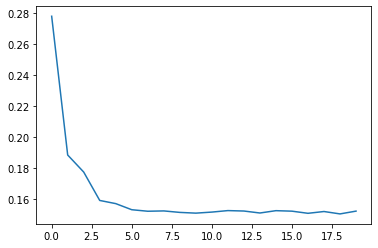

In [ ]:
# Cream el vostre DataLoader amb opcions personalitzades
loader = core.DataLoader(dataset, batch_size=2, shuffle=True)

model = core.Model(['jack', 'king', 'ten', 'nine', 'ace', 'queen'])
losses = model.fit(loader, val_dataset, epochs=20, verbose=True)

plt.plot(losses)  # Visualize loss throughout training
plt.show()

model.save('model_carta_3.pth')  # Save model to a file


In [ ]:
# Directly access underlying torchvision model for even more control
torch_model = model.get_internal_model()
print(type(torch_model))

<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


In [ ]:
from detecto import visualize
image = utils.read_image('val_images/cam_image4.jpg')

labels, boxes, scores = model.predict(image)
visualize.show_labeled_image(image, boxes, labels)

In [ ]:
model.save('model_carta_2.pth')

# Proba del model

In [ ]:
# Instanciem els inports corresponents 
from detecto import core, utils, visualize

In [ ]:
model = Model.load('model_weights.pth', ['tick', 'gate'])

In [ ]:
image = utils.read_image('images/IMG_2387.JPG')
model = core.Model(['person'])

labels, boxes, scores = model.predict(image)
visualize.show_labeled_image(image, boxes, labels)

In [ ]:
from detecto import core, utils, visualize
image = utils.read_image('val_images/IMG_2560.JPG')

model = core.Model.load('model_carta_3.pth', ['jack', 'king', 'ten', 'nine', 'ace', 'queen'])

labels, boxes, scores = model.predict(image)
visualize.show_labeled_image(image, boxes, labels)